# Gaps on structure functions: demo of pipeline

- Inspired by existing code
- Test on one PSP to start, then two PSP and one Wind for training and testing
- Check against target dataframes as you go

### 0. Import dependencies

In [1]:
import pickle
import pandas as pd
import numpy as np
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.params as params
import src.sf_funcs as sf
import sys
import src.data_import_funcs as dif
import json
import glob
import importlib
import matplotlib.pyplot as plt
#plt.rcParams.update({"font.size": 16})
import matplotlib.dates as mdates

In [2]:
# For current Wind importing

sys_arg_dict = {
    # arg1
    "mag_path": params.mag_path,
    "proton_path": params.proton_path,
    "electron_path": params.electron_path,
    # arg2
    "mag_vars": [params.timestamp, params.Bwind, params.Bwind_vec],
    "proton_vars": [params.timestamp, params.np, params.Tp],
    "electron_vars": [params.timestamp, params.ne, params.Te],
    # arg3
    "mag_thresh": params.mag_thresh,
    "proton_thresh": params.proton_thresh,
    "electron_thresh": params.electron_thresh,
    # arg4
    "dt_hr": params.dt_hr,
    "int_size": params.int_size,
    # arg5
    "dt_lr": params.dt_lr,
}

### 1. Download files

Run in terminal

In [3]:
# For selecting a range of dates

# wget --no-clobber --directory-prefix=data/raw/psp  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_20181102{00..12}_v02.cdf
# wget --no-clobber --directory-prefix=data/raw/wind/ https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/2016/wi_h2_mfi_201601{01..07}_v05.cdf

# For entire folders

# wget --no-clobber --directory-prefix=data/raw/psp --recursive -np -nv -nH --cut-dirs=7 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
# wget --no-clobber --directory-prefix=data/raw/wind --recursive -np -nv -nH --cut-dirs=2 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/

### 2. Read in data and split into standardised intervals

#### PSP data

In [4]:
raw_file_list = sorted(glob.iglob("data/raw/psp/" + "/*.cdf"))
print(raw_file_list)

['data/raw/psp\\psp_fld_l2_mag_rtn_2018110200_v02.cdf', 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110206_v02.cdf', 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110212_v02.cdf']


In [5]:
psp_data = dif.read_cdfs(
    [raw_file_list[0]],  # LIMIT HERE!
    {"epoch_mag_RTN": (0), "psp_fld_l2_mag_RTN": (0, 3), "label_RTN": (0, 3)},
)
psp_data_ready = dif.extract_components(
    psp_data,
    var_name="psp_fld_l2_mag_RTN",
    label_name="label_RTN",
    time_var="epoch_mag_RTN",
    dim=3,
)
psp_df = pd.DataFrame(psp_data_ready)
psp_df["Time"] = pd.to_datetime("2000-01-01 12:00") + pd.to_timedelta(
    psp_df["epoch_mag_RTN"], unit="ns"
)
psp_df = psp_df.drop(columns="epoch_mag_RTN").set_index("Time")

df_raw = psp_df["B_R"]

print(df_raw.info())
print(df_raw.head())

reading file  data/raw/psp\psp_fld_l2_mag_rtn_2018110200_v02.cdf
Done reading data
<class 'pandas.core.series.Series'>
DatetimeIndex: 1582027 entries, 2018-11-02 00:01:09.195182976 to 2018-11-02 06:01:09.171900544
Series name: B_R
Non-Null Count    Dtype  
--------------    -----  
1582027 non-null  float64
dtypes: float64(1)
memory usage: 24.1 MB
None
Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64


#### Wind data
Takes a while due to large files

In [6]:
# raw_file_list = sorted(glob.iglob("data/raw/wind/" + "/*.cdf"))
# print(raw_file_list)

In [7]:
# df = utils.pipeline(
#     raw_file_list[0],
#     varlist=sys_arg_dict["mag_vars"],
#     thresholds=sys_arg_dict["mag_thresh"],
#     cadence=sys_arg_dict["dt_hr"],
# )

# print("Reading {0}: {1:.2f}% missing".format(raw_file_list[0], df.iloc[:,0].isna().sum()/len(df)*100))

# # Ensuring observations are in chronological order
# df_wind_hr = df.sort_index()

# # df_wind_hr = pd.read_pickle("data/processed/" + params.mag_path + params.dt_hr + ".pkl")
# df_wind_hr = df_wind_hr.rename(
#     columns={
#         params.Bwind: "Bwind",
#         params.Bx: "Bx",
#         params.By: "By",
#         params.Bz: "Bz",
#     }
# )

# missing = df_wind_hr.iloc[:, 0].isna().sum() / len(df_wind_hr)

# if missing > 0.4:
#     # Replacing values in lists with na
#     print("Large missing %")
# else:
#     int_wind_hr = df_wind_hr.interpolate().ffill().bfill()

# df_raw = int_wind_hr["Bx"]

# print(df_raw.info())
# print(df_raw.head())

In [8]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.2f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}\n".format(np.std(x)))

### 0PTIONAL CODE END ###

No missing data
Length of interval: 1582027
Duration of interval: 0 days 05:59:59.976717568
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.24 Hz (2dp)
Mean = -28.383399058746512
Standard deviation = 18.777635215345533



In [9]:
times_to_gap = 2

In [10]:
tc_approx = 500  # s: 500 for PSP, 2000 for Wind
cadence_approx = 0.1  # s: 0.1 for PSP, 1 for Wind

tc_n = 10  # Number of actual (computed) correlation times we want in our standardised interval...
interval_length = 10000  # ...across this many points

df = df_raw.resample(str(cadence_approx) + "S").mean()

ints = []
tc_list = []
cadence_list = []

time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [df],
    nlags=10000,
    plot=False,
)

tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

if tc == -1:
    tc = tc_approx
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc not found for this interval, setting to 500s (default) -> cadence = {new_cadence}s"
    )

else:
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc calculated to be {np.round(tc,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tc_n}tc across {interval_length} points)"
    )

tc_list.append(tc)
cadence_list.append(new_cadence)

try:
    interval_approx_resampled = df.resample(
        str(np.round(new_cadence, 3)) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        # Check if interval is complete
        if interval.isnull().sum() > 0:
            print("interval contains missing data even after down-sampling; skipping")
            # Note: due to merging cannot identify specific file with missing data here
            # only file list as here:
            # print("corresponding input file list: ", file_list_split[core])
        else:
            # print("Interval successfully processed")
            int_norm = utils.normalize(interval)
            ints.append(int_norm)

except Exception as e:
    print(f"An error occurred: {e}")

if len(ints) == 0:
    print("No good inputs found (ints is empty). Exiting.")
    exit(1)

# Logarithmically-spaced lags?
# vals = np.logspace(0, 3, 0.25 * len(ints[0]))
# lags = np.unique(vals.astype(int))
lags = np.arange(1, 0.25 * len(ints[0]))
powers = [0.5, 2]

print(
    "\nNumber of standardised intervals: ",
    len(ints),
    "about to be gapped",
    times_to_gap,
    "times",
)

tc calculated to be 736.2s -> cadence = 0.74s (for 10tc across 10000 points)

Number of standardised intervals:  2 about to be gapped 2 times


Text(0, 0.5, '$B_R$ (nT)')

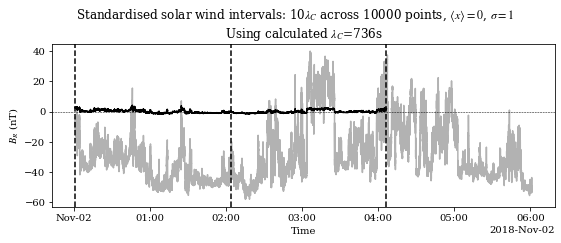

In [11]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(df, alpha=0.3, c="black")
plt.axvline(df.index[0], c="black", linestyle="dashed")
[
    plt.axvline(interval.index[-1], c="black", linestyle="dashed")
    for interval in ints
]
[plt.plot(interval, c="black") for interval in ints]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
plt.suptitle(
    f"Standardised solar wind intervals: {tc_n}$\lambda_C$ across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$", y= 1.05
)
# # Add subtitle
plt.title(f"Using calculated $\lambda_C$={int(tc)}s")

# ax.set_xlim(interval_list_approx[0].index[0], interval_list_approx[2].index[-1])
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel("$B_R$ (nT)")
# Tidy the timestamp x-axis
# plt.xticks(rotation=20)

# plt.savefig("plots/int_standardised_demo.png")

In [12]:
raw_ints_meta = pd.DataFrame({
    "raw_int_start": df.index[0],
    "raw_int_end": df.index[-1],
    "tc": tc_list,
    "cadence": cadence_list,
})
raw_ints_meta

,raw_int_start,raw_int_end,tc,cadence
0,2018-11-02 00:01:09.100,2018-11-02 06:01:09.100,736.199,0.736199


In [13]:
ints_meta = pd.DataFrame({
    "int_start": [interval.index[0] for interval in ints],
    "int_end": [interval.index[-1] for interval in ints],
})
ints_meta.reset_index(inplace=True)
ints_meta.rename(columns={"index": "int_index"}, inplace=True)
ints_meta

,int_index,int_start,int_end
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712
1,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712


### 3. Calculate the true SF and slope for each interval

In [14]:
lags = np.arange(1, 0.1 * len(ints[0]))
powers = [2]

In [15]:
sfs = pd.DataFrame()

for i, input in enumerate(ints):
    # print(f"\nCore {core} processing standardised interval {i}")
    good_output, slope = sf.compute_sf(pd.DataFrame(input), lags, powers, False, False, [10,100])
    
    good_output.insert(0, "int_index", i)
    sfs = pd.concat([sfs, good_output])
    ints_meta.loc[ints_meta["int_index"]==i, "slope"] = slope

sfs.head()

,int_index,lag,n,missing_percent,sf_0.5,sf_0.5_se,sf_2,sf_2_se
1.0,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594
2.0,0,2.0,9998,0.0,0.285889,0.001679,0.032877,0.001324
3.0,0,3.0,9997,0.0,0.311522,0.001843,0.047024,0.001895
4.0,0,4.0,9996,0.0,0.330458,0.001971,0.059901,0.002304
5.0,0,5.0,9995,0.0,0.344736,0.002068,0.071729,0.002690


[]

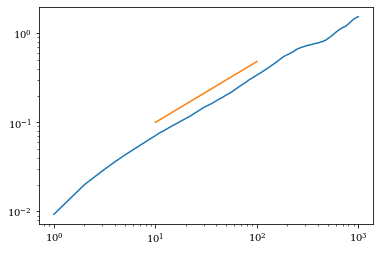

In [16]:
from src.data_import_funcs import pltpwrl
plt.plot(sfs.loc[sfs["int_index"]==1, "lag"], sfs.loc[sfs["int_index"]==1, "sf_2"])
pltpwrl(10,0.1, 10, 100, ints_meta.loc[ints_meta["int_index"]==1, "slope"].values)
plt.semilogx()
plt.semilogy()

Briefly limiting to processing single interval

### 4. Duplicate, gap and interpolate intervals, and calculate SFs and slopes

In [17]:
minimum_missing_chunks = 0.7

In [46]:
index_list = []
version_list = []
handling_list = []
missing_list = []
slopes_list = []

sfs_copies = pd.DataFrame()
ints_copies = pd.DataFrame()

for index in range(len(ints)):
    input = ints[index]

    for j in range(times_to_gap):
        total_removal = np.random.uniform(0, 0.95)
        ratio_removal = np.random.uniform(minimum_missing_chunks, 1)
        # print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        # print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_temp, bad_input_ind, prop_removed = ts.remove_data(
            input, prop_remove_chunks, chunks=np.random.randint(1, 10)
        )
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_temp, prop_remove_unif
        )
        if prop_removed >= 0.95 or prop_removed == 0:
            # print(">95% or 0% data removed, skipping")
            continue

        bad_output, slope = sf.compute_sf(pd.DataFrame(bad_input), lags, powers, False, False, [10,100])
        bad_output["int_index"] = index
        bad_output["version"] = j
        bad_output["gap_handling"] = "none"
        sfs_copies = pd.concat([sfs_copies, bad_output])

        for handling in ["none", "lint"]:
            index_list.append(index)
            version_list.append(j)
            missing_list.append(prop_removed*100)
            handling_list.append(handling)

            if handling == "none":
                slopes_list.append(slope)
                # Once we are done with computing the SF, add some metadata to the interval
                bad_input_df = pd.DataFrame(bad_input)
                bad_input_df.reset_index(inplace=True)
                bad_input_df["int_index"] = index
                bad_input_df["version"] = j
                bad_input_df["gap_handling"] = handling
                ints_copies = pd.concat([ints_copies, bad_input_df])

            elif handling == "lint":
                interp_input = bad_input.interpolate(method="linear")
                interp_output, slope = sf.compute_sf(pd.DataFrame(interp_input), lags, powers, False, False, [10,100])
                slopes_list.append(slope)
                
                # # Once we are done with computing the SF, add some metadata to the interval
                interp_input_df = pd.DataFrame(interp_input)
                interp_input_df.reset_index(inplace=True)
                interp_input_df["int_index"] = index
                interp_input_df["version"] = j
                interp_input_df["gap_handling"] = handling
                ints_copies = pd.concat([ints_copies, interp_input_df])

                interp_output["int_index"] = index
                interp_output["version"] = j
                interp_output["gap_handling"] = handling
                
                # Correcting sample size and uncertainty for linear interpolation, same values as no handling
                interp_output["missing_percent"] = bad_output["missing_percent"]
                interp_output["sf_2_se"] = bad_output["sf_2_se"]

                sfs_copies = pd.concat([sfs_copies, interp_output])

In [47]:
ints_copies_meta = pd.DataFrame({"int_index": index_list, "version": version_list, "missing_percent_overall": missing_list, "gap_handling": handling_list, "slope": slopes_list})

### 5. Calculate errors relative to true values

Join original and copies dataframes and do column operation

In [48]:
ints_copies_meta = pd.merge(ints_meta, ints_copies_meta, how="inner", on="int_index", suffixes=("_orig", ""))
ints_copies_meta["slope_pe"] = (ints_copies_meta["slope"] - ints_copies_meta["slope_orig"]) / ints_copies_meta["slope_orig"] * 100
ints_copies_meta["slope_ape"] = np.abs(ints_copies_meta["slope_pe"])
ints_copies_meta

,int_index,int_start,int_end,slope_orig,version,missing_percent_overall,gap_handling,slope,slope_pe,slope_ape
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,58.77,none,0.665864,3.042033,3.042033
1,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,58.77,lint,0.670623,3.778476,3.778476
2,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,46.20,none,0.654609,1.300275,1.300275
3,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,46.20,lint,0.658828,1.953119,1.953119
4,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,61.49,none,0.642818,-5.847735,5.847735
5,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,61.49,lint,0.743794,8.941998,8.941998
6,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,55.22,none,0.664434,-2.681686,2.681686
7,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,55.22,lint,0.693524,1.578978,1.578978


In [49]:
sfs_copies = pd.merge(sfs, sfs_copies, how="inner", on=["int_index", "lag"], suffixes=("_orig", ""))
sfs_copies["sf_2_pe"] = (sfs_copies["sf_2"] - sfs_copies["sf_2_orig"]) / sfs_copies["sf_2_orig"] * 100
sfs_copies

,int_index,lag,n_orig,missing_percent_orig,sf_0.5_orig,sf_0.5_se_orig,sf_2_orig,sf_2_se_orig,n,missing_percent,sf_0.5,sf_0.5_se,sf_2,sf_2_se,version,gap_handling,sf_2_pe
0,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,3489,65.106511,0.240423,0.002415,0.016796,0.001096,0,none,6.966980
1,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,9999,65.106511,0.120964,0.001437,0.007291,0.001096,0,lint,-53.563071
2,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,4072,59.275928,0.242872,0.002238,0.016937,0.001021,1,none,7.866328
3,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,9997,59.275928,0.161334,0.001475,0.009210,0.001021,1,lint,-41.341523
4,0,2.0,9998,0.0,0.285889,0.001679,0.032877,0.001324,3472,65.273055,0.286313,0.002909,0.035882,0.002701,0,none,9.141711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7987,1,998.0,9002,0.0,0.884619,0.004419,1.538456,0.021700,9002,83.470340,0.785672,0.004476,1.245409,0.062698,1,lint,-19.048117
7988,1,999.0,9001,0.0,0.884710,0.004421,1.539483,0.021722,1190,86.779247,0.773063,0.011051,0.976157,0.046154,0,none,-36.591879
7989,1,999.0,9001,0.0,0.884710,0.004421,1.539483,0.021722,9001,86.779247,0.734391,0.003857,0.895933,0.046154,0,lint,-41.803007
7990,1,999.0,9001,0.0,0.884710,0.004421,1.539483,0.021722,1495,83.390734,0.999670,0.010186,1.996533,0.063147,1,none,29.688539


Calculate MAPE for each interval copy

In [50]:
for i in range(len(ints)):
    for j in range(times_to_gap):
        for gap_handling in ["none", "lint"]:
            mape = np.mean(np.abs(sfs_copies.loc[(sfs_copies["int_index"]==i) & (sfs_copies["version"]==j) & (sfs_copies["gap_handling"]==gap_handling), "sf_2_pe"]))
            ints_copies_meta.loc[(ints_copies_meta["int_index"]==i) & (ints_copies_meta["version"]==j) & (ints_copies_meta["gap_handling"]==gap_handling), "mape"] = mape

ints_copies_meta

,int_index,int_start,int_end,slope_orig,version,missing_percent_overall,gap_handling,slope,slope_pe,slope_ape,mape
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,58.77,none,0.665864,3.042033,3.042033,30.389777
1,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,58.77,lint,0.670623,3.778476,3.778476,36.695675
2,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,46.20,none,0.654609,1.300275,1.300275,7.545742
3,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,46.20,lint,0.658828,1.953119,1.953119,18.210674
4,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,61.49,none,0.642818,-5.847735,5.847735,24.991782
5,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,61.49,lint,0.743794,8.941998,8.941998,47.858371
6,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,55.22,none,0.664434,-2.681686,2.681686,59.551617
7,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,55.22,lint,0.693524,1.578978,1.578978,24.102274


<Axes: >

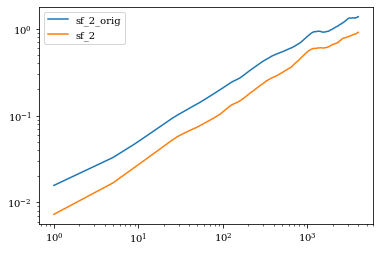

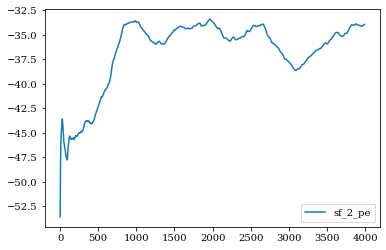

In [52]:
check = sfs_copies[(sfs_copies["int_index"]==0) & (sfs_copies["version"]==0) & (sfs_copies["gap_handling"]=="lint")]
check[["sf_2_orig", "sf_2"]].plot()
plt.semilogx()
plt.semilogy()
check[[ "sf_2_pe"]].plot()

In [53]:
sfs_copies

,int_index,lag,n_orig,missing_percent_orig,sf_0.5_orig,sf_0.5_se_orig,sf_2_orig,sf_2_se_orig,n,missing_percent,sf_0.5,sf_0.5_se,sf_2,sf_2_se,version,gap_handling,sf_2_pe
0,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,3489,65.106511,0.240423,0.002415,0.016796,0.001096,0,none,6.966980
1,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,9999,65.106511,0.120964,0.001437,0.007291,0.001096,0,lint,-53.563071
2,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,4072,59.275928,0.242872,0.002238,0.016937,0.001021,1,none,7.866328
3,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,9997,59.275928,0.161334,0.001475,0.009210,0.001021,1,lint,-41.341523
4,0,2.0,9998,0.0,0.285889,0.001679,0.032877,0.001324,3472,65.273055,0.286313,0.002909,0.035882,0.002701,0,none,9.141711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7987,1,998.0,9002,0.0,0.884619,0.004419,1.538456,0.021700,9002,83.470340,0.785672,0.004476,1.245409,0.062698,1,lint,-19.048117
7988,1,999.0,9001,0.0,0.884710,0.004421,1.539483,0.021722,1190,86.779247,0.773063,0.011051,0.976157,0.046154,0,none,-36.591879
7989,1,999.0,9001,0.0,0.884710,0.004421,1.539483,0.021722,9001,86.779247,0.734391,0.003857,0.895933,0.046154,0,lint,-41.803007
7990,1,999.0,9001,0.0,0.884710,0.004421,1.539483,0.021722,1495,83.390734,0.999670,0.010186,1.996533,0.063147,1,none,29.688539


In [54]:
ints_copies_meta

,int_index,int_start,int_end,slope_orig,version,missing_percent_overall,gap_handling,slope,slope_pe,slope_ape,mape
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,58.77,none,0.665864,3.042033,3.042033,30.389777
1,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,58.77,lint,0.670623,3.778476,3.778476,36.695675
2,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,46.20,none,0.654609,1.300275,1.300275,7.545742
3,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,46.20,lint,0.658828,1.953119,1.953119,18.210674
4,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,61.49,none,0.642818,-5.847735,5.847735,24.991782
5,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,61.49,lint,0.743794,8.941998,8.941998,47.858371
6,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,55.22,none,0.664434,-2.681686,2.681686,59.551617
7,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,55.22,lint,0.693524,1.578978,1.578978,24.102274


In [64]:
raw_ints_meta

,raw_int_start,raw_int_end,tc,cadence
0,2018-11-02 00:01:09.100,2018-11-02 06:01:09.100,736.199,0.736199


In [65]:
ints_meta

,int_index,int_start,int_end,slope
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207
1,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743


In [66]:
ints_copies_meta

,int_index,int_start,int_end,slope_orig,version,missing_percent_overall,gap_handling,slope,slope_pe,slope_ape,mape
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,58.77,none,0.665864,3.042033,3.042033,30.389777
1,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,58.77,lint,0.670623,3.778476,3.778476,36.695675
2,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,46.20,none,0.654609,1.300275,1.300275,7.545742
3,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,46.20,lint,0.658828,1.953119,1.953119,18.210674
4,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,61.49,none,0.642818,-5.847735,5.847735,24.991782
5,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,0,61.49,lint,0.743794,8.941998,8.941998,47.858371
6,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,55.22,none,0.664434,-2.681686,2.681686,59.551617
7,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712,0.682743,1,55.22,lint,0.693524,1.578978,1.578978,24.102274


In [69]:
ints_copies

,Time,B_R,gap_handling,int_index,version
0,2018-11-02 00:01:08.448,2.316472,none,0,0
1,2018-11-02 00:01:09.184,2.338880,none,0,0
2,2018-11-02 00:01:09.920,2.412652,none,0,0
3,2018-11-02 00:01:10.656,2.423617,none,0,0
4,2018-11-02 00:01:11.392,NaN,none,0,0
...,...,...,...,...,...
79995,2018-11-02 04:06:24.768,1.798370,lint,1,1
79996,2018-11-02 04:06:25.504,1.886993,lint,1,1
79997,2018-11-02 04:06:26.240,1.943150,lint,1,1
79998,2018-11-02 04:06:26.976,1.920057,lint,1,1


In [70]:
sfs

,int_index,lag,n,missing_percent,sf_0.5,sf_0.5_se,sf_2,sf_2_se
1.0,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594
2.0,0,2.0,9998,0.0,0.285889,0.001679,0.032877,0.001324
3.0,0,3.0,9997,0.0,0.311522,0.001843,0.047024,0.001895
4.0,0,4.0,9996,0.0,0.330458,0.001971,0.059901,0.002304
5.0,0,5.0,9995,0.0,0.344736,0.002068,0.071729,0.002690
...,...,...,...,...,...,...,...,...
995.0,1,995.0,9005,0.0,0.884928,0.004412,1.535675,0.021624
996.0,1,996.0,9004,0.0,0.884943,0.004411,1.536413,0.021649
997.0,1,997.0,9003,0.0,0.884796,0.004415,1.537439,0.021672
998.0,1,998.0,9002,0.0,0.884619,0.004419,1.538456,0.021700


In [71]:
sfs_copies

,int_index,lag,n_orig,missing_percent_orig,sf_0.5_orig,sf_0.5_se_orig,sf_2_orig,sf_2_se_orig,n,missing_percent,sf_0.5,sf_0.5_se,sf_2,sf_2_se,version,gap_handling,sf_2_pe
0,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,3489,65.106511,0.240423,0.002415,0.016796,0.001096,0,none,6.966980
1,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,9999,65.106511,0.120964,0.001437,0.007291,0.001096,0,lint,-53.563071
2,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,4072,59.275928,0.242872,0.002238,0.016937,0.001021,1,none,7.866328
3,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,9997,59.275928,0.161334,0.001475,0.009210,0.001021,1,lint,-41.341523
4,0,2.0,9998,0.0,0.285889,0.001679,0.032877,0.001324,3472,65.273055,0.286313,0.002909,0.035882,0.002701,0,none,9.141711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7987,1,998.0,9002,0.0,0.884619,0.004419,1.538456,0.021700,9002,83.470340,0.785672,0.004476,1.245409,0.062698,1,lint,-19.048117
7988,1,999.0,9001,0.0,0.884710,0.004421,1.539483,0.021722,1190,86.779247,0.773063,0.011051,0.976157,0.046154,0,none,-36.591879
7989,1,999.0,9001,0.0,0.884710,0.004421,1.539483,0.021722,9001,86.779247,0.734391,0.003857,0.895933,0.046154,0,lint,-41.803007
7990,1,999.0,9001,0.0,0.884710,0.004421,1.539483,0.021722,1495,83.390734,0.999670,0.010186,1.996533,0.063147,1,none,29.688539


#### 5b. Get overall errors and plot trends



### 6. For PSP training set, create 2D and 3D heatmaps and export

,int_index,lag,n_orig,missing_percent_orig,sf_0.5_orig,sf_0.5_se_orig,sf_2_orig,sf_2_se_orig,n,missing_percent,sf_0.5,sf_0.5_se,sf_2,sf_2_se,version,gap_handling,sf_2_pe
0,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,3489,65.106511,0.240423,0.002415,0.016796,0.001096,0,none,6.966980
2,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,4072,59.275928,0.242872,0.002238,0.016937,0.001021,1,none,7.866328
4,0,2.0,9998,0.0,0.285889,0.001679,0.032877,0.001324,3472,65.273055,0.286313,0.002909,0.035882,0.002701,0,none,9.141711
6,0,2.0,9998,0.0,0.285889,0.001679,0.032877,0.001324,4072,59.271854,0.291422,0.002701,0.036993,0.002432,1,none,12.520821
8,0,3.0,9997,0.0,0.311522,0.001843,0.047024,0.001895,3488,65.109533,0.315303,0.003242,0.053589,0.003865,0,none,13.960788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7982,1,997.0,9003,0.0,0.884796,0.004415,1.537439,0.021672,1491,83.438854,0.994374,0.010252,1.975180,0.062764,1,none,28.472083
7984,1,998.0,9002,0.0,0.884619,0.004419,1.538456,0.021700,1191,86.769607,0.773206,0.011075,0.978560,0.046233,0,none,-36.393377
7986,1,998.0,9002,0.0,0.884619,0.004419,1.538456,0.021700,1488,83.470340,0.997261,0.010187,1.976591,0.062698,1,none,28.478881
7988,1,999.0,9001,0.0,0.884710,0.004421,1.539483,0.021722,1190,86.779247,0.773063,0.011051,0.976157,0.046154,0,none,-36.591879


In [75]:
sfs_copies[sfs_copies["gap_handling"]=="none"]

,int_index,lag,n_orig,missing_percent_orig,sf_0.5_orig,sf_0.5_se_orig,sf_2_orig,sf_2_se_orig,n,missing_percent,sf_0.5,sf_0.5_se,sf_2,sf_2_se,version,gap_handling,sf_2_pe
0,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,3489,65.106511,0.240423,0.002415,0.016796,0.001096,0,none,6.966980
2,0,1.0,9999,0.0,0.239586,0.001398,0.015702,0.000594,4072,59.275928,0.242872,0.002238,0.016937,0.001021,1,none,7.866328
4,0,2.0,9998,0.0,0.285889,0.001679,0.032877,0.001324,3472,65.273055,0.286313,0.002909,0.035882,0.002701,0,none,9.141711
6,0,2.0,9998,0.0,0.285889,0.001679,0.032877,0.001324,4072,59.271854,0.291422,0.002701,0.036993,0.002432,1,none,12.520821
8,0,3.0,9997,0.0,0.311522,0.001843,0.047024,0.001895,3488,65.109533,0.315303,0.003242,0.053589,0.003865,0,none,13.960788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7982,1,997.0,9003,0.0,0.884796,0.004415,1.537439,0.021672,1491,83.438854,0.994374,0.010252,1.975180,0.062764,1,none,28.472083
7984,1,998.0,9002,0.0,0.884619,0.004419,1.538456,0.021700,1191,86.769607,0.773206,0.011075,0.978560,0.046233,0,none,-36.393377
7986,1,998.0,9002,0.0,0.884619,0.004419,1.538456,0.021700,1488,83.470340,0.997261,0.010187,1.976591,0.062698,1,none,28.478881
7988,1,999.0,9001,0.0,0.884710,0.004421,1.539483,0.021722,1190,86.779247,0.773063,0.011051,0.976157,0.046154,0,none,-36.591879


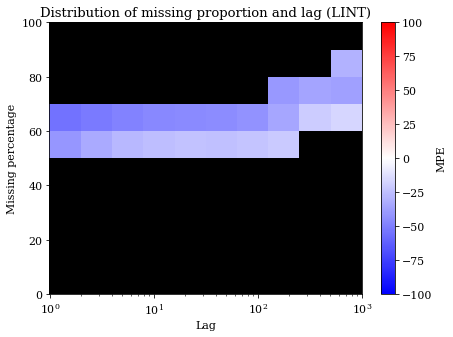

In [115]:
importlib.reload(sf)

missing_measure = "missing_percent"
n_bins = 10

heatmap_bin_vals_2d, heatmap_bin_edges_2d, lookup_table_2d = (
    sf.create_heatmap_lookup(
        sfs_copies[sfs_copies["gap_handling"]=="lint"], missing_measure, n_bins, log=True
    )
)

fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(
    heatmap_bin_edges_2d[0],
    heatmap_bin_edges_2d[1],
    heatmap_bin_vals_2d.T,
    cmap="bwr",
)
plt.colorbar(label="MPE")
plt.clim(-100, 100)
plt.xlabel("Lag")
plt.ylabel("Missing percentage")
plt.title("Distribution of missing proportion and lag (LINT)")
ax.set_facecolor("black")
ax.set_xscale("log")

In [116]:
lookup_table_2d

,lag,missing_percent,mpe,mpe_sd,pe_min,pe_max,scaling,scaling_lower,scaling_upper
0,1.487531,55.0,-41.341523,0.000000,-41.341523,-41.341523,1.704783,1.704783,1.704783
1,1.487531,65.0,-55.162722,7.869103,-65.500105,-46.424990,2.230287,1.866542,2.898560
2,2.977669,55.0,-32.875559,2.222693,-35.098251,-30.652866,1.489770,1.442021,1.540791
3,2.977669,65.0,-52.023796,9.220092,-65.071836,-42.423086,2.084367,1.736807,2.863019
4,5.950587,55.0,-27.890519,0.760162,-29.031110,-26.952967,1.386780,1.368981,1.409068
5,5.950587,65.0,-48.708322,10.851242,-63.973231,-35.937219,1.949634,1.560969,2.775714
6,11.881744,55.0,-25.768675,0.297120,-26.384149,-25.280191,1.347140,1.338333,1.358403
7,11.881744,65.0,-46.730310,11.731621,-63.082266,-32.252581,1.877240,1.476071,2.708725
8,23.714776,55.0,-23.917562,0.454457,-25.017056,-23.393220,1.314364,1.305367,1.333637
9,23.714776,65.0,-45.895679,10.513972,-60.201450,-31.824885,1.848281,1.466811,2.512654


In [117]:
importlib.reload(sf)

heatmap_bin_vals_3d, heatmap_bin_edges_3d, lookup_table_3d = (
    sf.create_heatmap_lookup_3D(
        sfs_copies[sfs_copies["gap_handling"]=="lint"], missing_measure, n_bins, True
    )
)

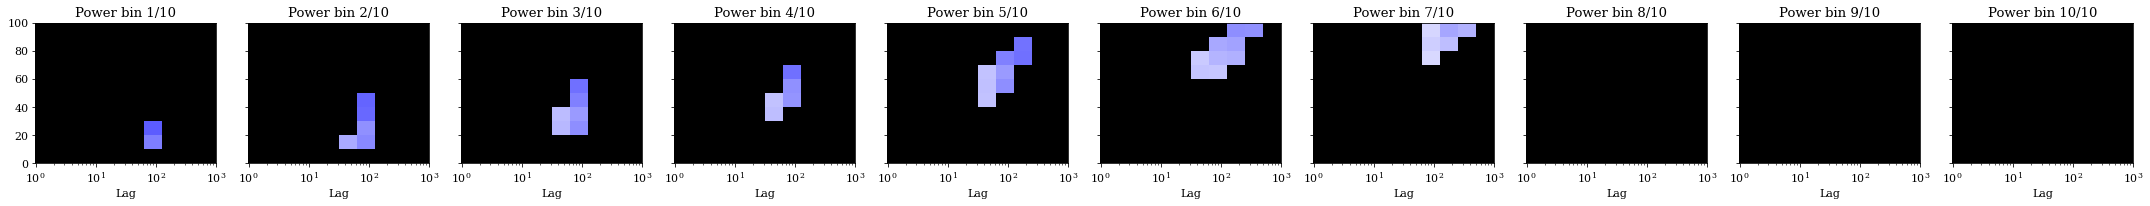

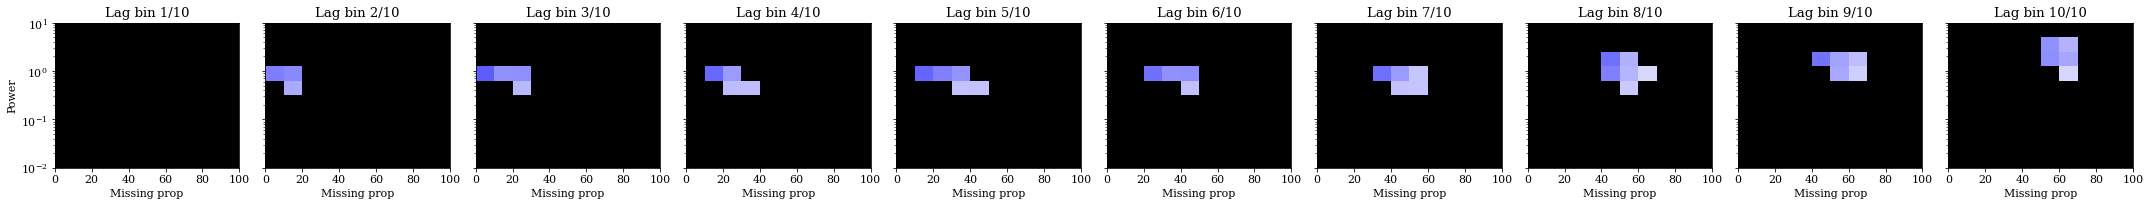

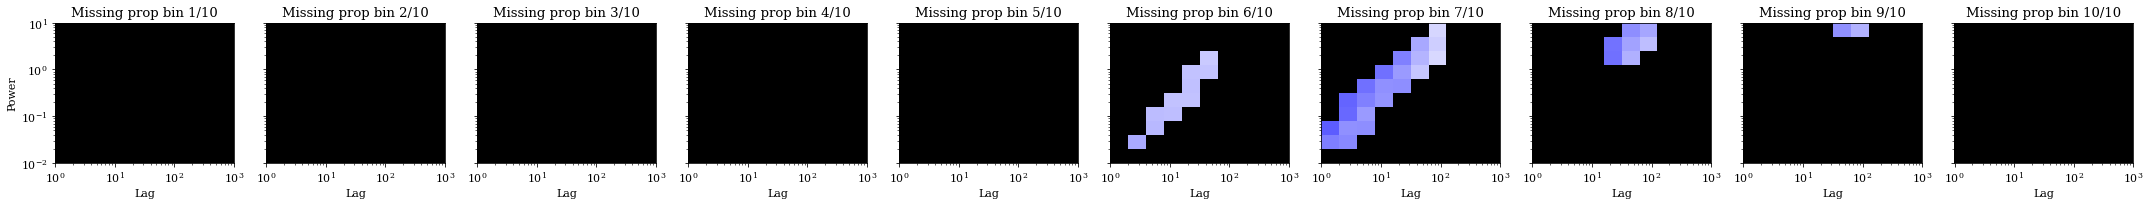

In [118]:
# Plotting 3D heatmaps

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[1],
        heatmap_bin_vals_3d[:, :, i],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Lag")
    plt.ylabel("Missing proportion")
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].set_title(
        f"Power bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
#plt.savefig(save_dir + f"error_heatmap_b_{n_bins}_3d_power.png")
#plt.close()

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[1],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[i, :, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    ax[i].set_xlabel("Missing prop")
    ax[i].set_ylabel("Power")
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogy()
    ax[i].set_title(
        f"Lag bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Missing prop")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
#plt.savefig(save_dir + f"error_heatmap_b_{n_bins}_3d_lag.png")
#plt.close()

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[:, i, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].semilogy()
    ax[i].set_title(
        f"Missing prop bin {i+1}/{n_bins}".format(
            np.round(heatmap_bin_edges_3d[2][i], 2)
        )
    )
    ax[i].set_xlabel("Lag")
    ax[i].set_ylabel("Power")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
#plt.savefig(save_dir + f"error_heatmap_b_{n_bins}_3d_missing.png")
#plt.close()


In [107]:
# Export the lookup table as a CSV
print("Exporting lookup table to CSV")
#lookup_table_3d.to_csv(save_dir + f"lookup_table_3d_b_{n_bins}.csv")

Exporting lookup table to CSV


### 7. For PSP and Wind test sets, apply the correction factor and calculate slopes

In [125]:
importlib.reload(sf)

# Apply 2D and 3D scaling to test set, report avg errors
print(f"Correcting test set intervals using 2D error heatmap with {n_bins} bins")
sfs_copies = sf.compute_scaling(
    sfs_copies, missing_measure, lookup_table_2d
)
sfs_copies.head()

Correcting test set intervals using 2D error heatmap with 10 bins


In [ ]:
# # Quick check of results
index = 1
n_versions = 2

fig, ax = plt.subplots(n_versions, 2, figsize=(10, n_versions*3))
for i in range(n_versions):
    ax[i, 0].plot(ints[index], alpha=0.5, c="black")
    ax[i, 0].plot(ints_copies.loc[((ints_copies["int_index"]==index) & (ints_copies["gap_handling"]=="lint") & (ints_copies["version"]==i)),"B_R"], c="blue")
    ax[i, 0].plot(ints_copies.loc[((ints_copies["int_index"]==index) & (ints_copies["gap_handling"]=="none") & (ints_copies["version"]==i)),"B_R"], c="red")

    ax[i, 1].plot(sfs.loc[sfs["int_index"]==index,"lag"],
                  sfs.loc[sfs["int_index"]==index,"sf_2"], 
                  alpha=0.5, 
                  c="black")
    ax[i, 1].plot(
        sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["gap_handling"]=="lint") & (sfs_copies["version"]==i)),"lag"],
        sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["gap_handling"]=="lint") & (sfs_copies["version"]==i)),"sf_2"], 
        c="blue")
    ax[i, 1].plot(
        sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["gap_handling"]=="none") & (sfs_copies["version"]==i)),"lag"],
        sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["gap_handling"]=="none") & (sfs_copies["version"]==i)),"sf_2"], 
        c="red")
    ax[i, 1].plot(
        sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["gap_handling"]=="none") & (sfs_copies["version"]==i)),"lag"],
        sfs_copies.loc[((sfs_copies["int_index"]==index) & (sfs_copies["gap_handling"]=="none") & (sfs_copies["version"]==i)),"sf_2"], 
        c="red")

    pltpwrl(10,0.1, 10, 100, ints_copies_meta.loc[((ints_copies_meta["int_index"]==index) & (ints_copies_meta["gap_handling"]=="none") & (ints_copies_meta["version"]==i)),"slope"].values, c="red", ax=ax[i, 1])
    pltpwrl(10,0.1, 10, 100, ints_copies_meta.loc[((ints_copies_meta["int_index"]==index) & (ints_copies_meta["gap_handling"]=="lint") & (ints_copies_meta["version"]==i)),"slope"].values, c="blue", ax=ax[i, 1])
    pltpwrl(10,0.1, 10, 100, ints_meta.loc[ints_meta["int_index"]==index,"slope"].values, ax=ax[i, 1], c="black")

    ax[i, 1].semilogx()
    ax[i, 1].semilogy()
#plt.savefig("data/processed/validation_plot.png")
#print("Validation plot saved")

In [ ]:
print(f"Correcting test set intervals using 3D error heatmap with {n_bins} bins")
# Overriding with the version including the 3D scaling (as well as 2d) to save memory
test_set_corrected = sf.compute_scaling_3d(
    sfs_copies, missing_measure, lookup_table_3d
)

### 8. Again calculate errors relative to true values